# cross-section correction around $\phi_\mu \sim 0$ and $\phi_p \sim 0$

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline
from matplotlib import patches

versions:
{   'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'beam off': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'beam on': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'data date': '2018_08_16',
    'overlay date': '2018_09_22'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.051017899728 = N(POT on beam)/N(POT MC)


In [16]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/Xsec_extraction/'

In [3]:
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected overlay files from , loading them...
9538 selected CC1p events overlay
found  462 selected on beam and 15 beam off events...
found selected genie CC1p...


# apply the efficiency weights

In [4]:
compute_eff_weights(   beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p ,                       
                       overlay=selected_overlay_concat) 

In [5]:
compute_eff_weights(   beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p ,                       
                       overlay=selected_overlay_concat
                       ,ob_1='Pp',ob_2='cos(theta(p))',ob_3='phi(p)'
                       ,reco_1='reco_Pp',reco_2='reco_Pp_cos_theta',reco_3='reco_Pp_phi'
                       ,true_1='truth_Pp',true_2='truth_Pp_cos_theta',true_3='truth_Pp_phi')

In [17]:
def get_Xsecs(do_corr_phi_0=False, debug=0, do_proton=True, do_muon=True, do_P=True, do_cos_theta=True, do_phi=True, do_print_Xsec=True,
              remove_last_cos_theta_mu_bin=False):#{
    Xsec_dict = dict()
    for particle,do_particle in zip(['mu','p'],[do_muon,do_proton]):#{
        if do_particle==False: continue
        if debug: print 'getting cross-section with P'+particle+' weight'
        for i,(observable,ivar,do_var) in enumerate(zip(['P'+particle,'cos(theta('+particle+'))','phi('+particle+')']
                                                             ,[(1,4),(2,5),(3,6)]
                                                             ,[do_P,do_cos_theta,do_phi])):#{
            if do_var==False: continue
            var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
            mul = 180./np.pi if 'phi' in observable else 1
            beam_on , beam_off , overlay , CC1p = selected_beam_on,selected_beam_off,selected_overlay_concat,selected_CC1p
            if remove_last_cos_theta_mu_bin:#{
                beam_on = beam_on[beam_on['reco_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
                beam_off = beam_off[beam_off['reco_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
                overlay = overlay[overlay['reco_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
                CC1p = CC1p[CC1p['reco_Pmu_cos_theta']<Bins['cos(theta(mu))'][-2]]
            #}
            h = get_Xsec_1d(beam_on,beam_off,overlay,CC1p
                            ,var=var,bins=Bins[observable],bin_width=bin_width,wname='P'+particle+' weight',mul=mul
                            ,do_corr_phi_0=do_corr_phi_0)
            if i==0 and do_print_Xsec: print ('integrated Xsec: %.2f+/-%.2f'%(np.sum(h['Xsec']*bin_width),np.sqrt(np.sum(np.square(h['Xsec err'])*bin_width))),
                                                              'mc Xsec: %.2f+/-%.2f'%(np.sum(h['mc Xsec']*bin_width),np.sqrt(np.sum(np.square(h['mc Xsec err'])*bin_width))))
            
            if debug>1:  pp.pprint(h)
            Xsec_dict[observable] = h['Xsec']
            Xsec_dict[observable+' err'] = h['Xsec err']
            Xsec_dict['mc '+observable] = h['mc Xsec']
            Xsec_dict['mc '+observable+' err'] = h['mc Xsec err']
        #}
    #}
    return Xsec_dict

In [18]:
Xsec_dict = get_Xsecs( do_corr_phi_0=False , debug=0, do_print_Xsec=False )

In [39]:
def draw_phi_Xsecs(Xsec_dict=None,filename='Xsec_Pmu_phi_Pp_phi_no_correction',do_add_ellipses=False):
    fig=plt.figure(figsize=(20,8))
    for ip,(particle,iax) in enumerate(zip(['mu','p'],[(1,3),(2,4)])):
        print 'drawing cross-section with P'+particle+' weight'
        observable = 'phi('+particle+')'
        true = 'truth_P'+particle+'_phi'
        var,vtrue,bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
        mul = 180./np.pi
        h = dict()
        h['Xsec'],h['Xsec err'] = Xsec_dict[observable],Xsec_dict[observable+' err']
        h['mc Xsec'],h['mc Xsec err'] = Xsec_dict['mc '+observable], Xsec_dict['mc '+observable+' err']

        ax = fig.add_subplot(3,2,iax)
        plt.errorbar(x=mid,xerr=0.5*bin_width,y=h['Xsec'],yerr=h['Xsec err'],color=Colors['beam on'],fmt='o',label='data')
        ax.bar( x=mid , height=2*h['mc Xsec err'], bottom=h['mc Xsec']-h['mc Xsec err'], width=bin_width, color=Colors['CC1p'],label='overlay')
        if do_add_ellipses:
            if particle=='mu':
                e0 = patches.Ellipse((0, 0.012), 35, 0.02, color='red', linewidth=3, fill=False, zorder=2)
                ax.add_patch(e0)
            if particle=='p':
                e0 = patches.Ellipse((0, 0.011), 35, 0.013, color='red', linewidth=3, fill=False, zorder=2)
                ax.add_patch(e0)
                e_p_pi = patches.Ellipse((mid[0], 0.011), 30, 0.012, color='red', linewidth=3, fill=False, zorder=2)
                e_m_pi = patches.Ellipse((mid[-1], 0.011), 30, 0.012, color='red', linewidth=3, fill=False, zorder=2)
                ax.add_patch(e_p_pi)
                ax.add_patch(e_m_pi)
        set_axes(ax,'',y_label=get_Xsec_label(vlabel=vlabel,units=units)
                         ,do_add_grid=True,remove_ticks_x=True,do_add_legend=True if ip==1 else 0                                  
                         ,ylim=(0,1.1*np.max(ax.get_ylim())))    
        # residuals plot
        den, den_err = h['Xsec']-h['mc Xsec'],np.sqrt(np.square(h['Xsec err'])+np.square(h['mc Xsec err']))
        num, num_err = h['Xsec'],h['mc Xsec err']
        ratio = den/num
        ax = fig.add_subplot(3,2,5+ip)
        ratio_err = ratio*np.sqrt(np.square(den_err/den) + np.square(num_err/num))
        plt.errorbar(x=mid,xerr=0.5*bin_width,y=ratio,yerr=ratio_err,fmt='o',markersize=0,color='black')
        chi2,ndf = chi2_two_data_curves(h1=h['Xsec'],h1err=h['Xsec err'],h2=h['mc Xsec'],h2err=h['mc Xsec err'],bins=bins,debug=0)
        plt.text(mid[0]-30,0.94*np.min(ax.get_ylim()) + 0.06*np.max(ax.get_ylim()), r'$\chi^2/ndf=%.2f/%d$'%(chi2,ndf), fontsize=20)
        set_axes(ax,xlabel,y_label=r'(data-MC)/data',do_add_grid=True)
        plt.plot([np.min(bins),np.max(bins)],[0,0],'--',color='royalblue')            
    plt.tight_layout(h_pad=0.0)   
    save_figure(figures_path+filename+'.pdf')

drawing cross-section with Pmu weight
drawing cross-section with Pp weight
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/Xsec_extraction/Xsec_Pmu_phi_Pp_phi_no_correction.pdf


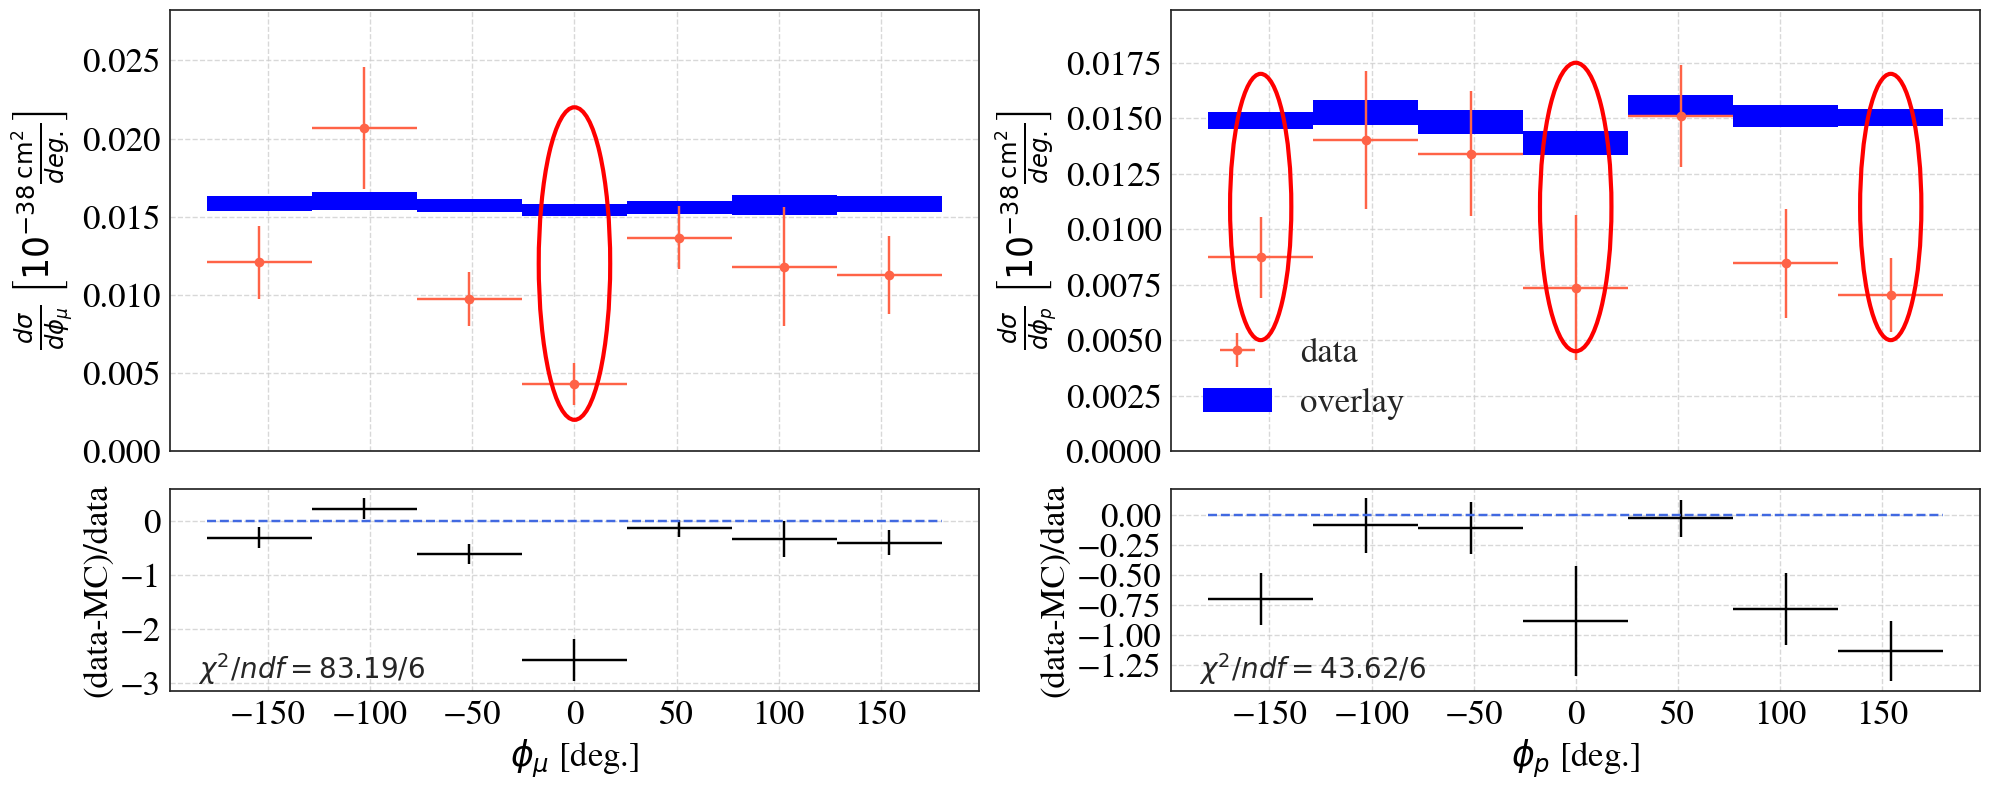

In [40]:
draw_phi_Xsecs(Xsec_dict=Xsec_dict,do_add_ellipses=True)

In [41]:
# iterative process for correction
for sam in [selected_beam_on,selected_beam_off,selected_CC1p,selected_overlay_concat]:
    sam['W(corr. phi~0)'] = 1
Xsec_dict = get_Xsecs( do_corr_phi_0=False , debug=0, do_print_Xsec=False )
correction, correction_arrays = dict(),dict()
correction_arrays['mu'] = []; correction_arrays['p'] = []; step=[]
correction['mu'] = correction['p'] = 1
current_correction = 10
i = 1
while np.abs(current_correction-1)>0.0001:
    step.append(i)
    for particle,var in zip(['mu','p'],
                            ['reco_Pmu_mcs_phi','reco_Pp_phi']):
        Xsec,Xsec_err = Xsec_dict['phi('+particle+')'],Xsec_dict['phi('+particle+') err']
        bins = Bins['phi('+particle+')']
        N = len(bins)-1; n = N/2
        Xsec_phi_0 = Xsec[n]
        Xsec_phi_not_0 = np.concatenate([Xsec[:n-1],Xsec[n+1:]])
        Xsec_err_phi_not_0 = np.concatenate([Xsec_err[:n-1],Xsec_err[n+1:]])
        mean_phi_not_0 = np.average(Xsec_phi_not_0 , weights=1./np.square(Xsec_err_phi_not_0))
        current_correction = mean_phi_not_0/Xsec_phi_0
        correction[particle] = correction[particle]*current_correction
        correction_arrays[particle].append( correction[particle] )
        # print 'Xsec:',Xsec
        # print 'Xsec_phi_0:',Xsec_phi_0
        #print 'mean_phi_not_0:',mean_phi_not_0
        # print 'current_correction:',current_correction
        for sam in [selected_beam_on,selected_beam_off,selected_CC1p,selected_overlay_concat]:
            indices_phi_0 = sam.index[(bins[n] <= 180./np.pi*sam[var]) & (180./np.pi*sam[var] < bins[n+1])].tolist()
            sam.loc[indices_phi_0,'W(corr. phi~0)'] = sam.loc[indices_phi_0,'W(corr. phi~0)'] * current_correction
        Xsec_dict = get_Xsecs( do_corr_phi_0=True , debug=0, do_print_Xsec=False )
        print 'corrected samples for ',particle,', computing Xsec'
    i = i+1
for particle in ['mu','p']: print 'correction for phi('+particle+')~0:',correction_arrays[particle][-1]
print 'done.'

corrected samples for  mu , computing Xsec
corrected samples for  p , computing Xsec
corrected samples for  mu , computing Xsec
corrected samples for  p , computing Xsec
corrected samples for  mu , computing Xsec
corrected samples for  p , computing Xsec
corrected samples for  mu , computing Xsec
corrected samples for  p , computing Xsec
correction for phi(mu)~0: 3.28131123527
correction for phi(p)~0: 1.68431269074
done.


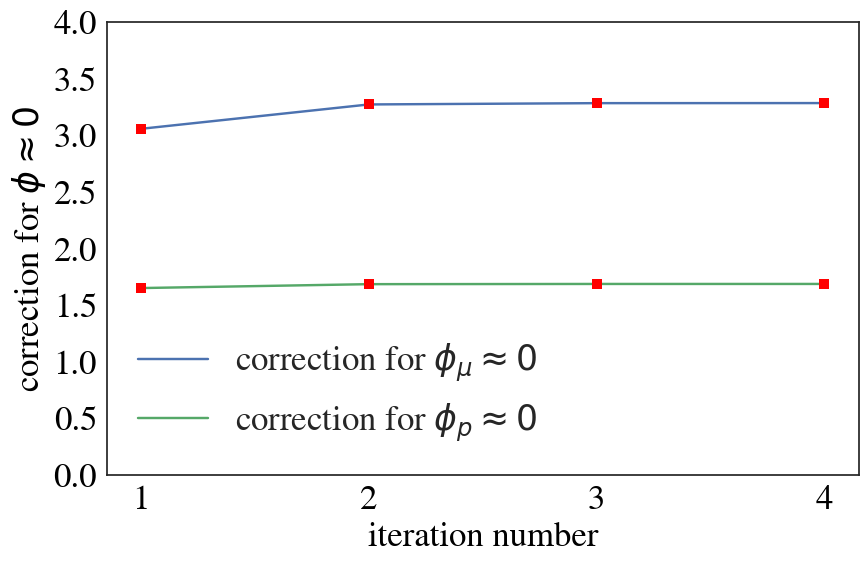

In [42]:
fig,ax=plt.subplots(figsize=(9.7,6))
plt.plot(step,correction_arrays['mu'],label=r'correction for $\phi_\mu \approx  0$')
plt.plot(step,correction_arrays['p'],label=r'correction for $\phi_p \approx 0$')
plt.errorbar(step,correction_arrays['p'],label=None,fmt='s',color='red')
plt.errorbar(step,correction_arrays['mu'],label=None,fmt='s',color='red')


set_axes(ax,r'iteration number',r'correction for $\phi \approx  0$',do_add_legend=True,xticks=[1,2,3,4],ylim=(0,4))
plt.savefig(figures_path + 'phi_0_correction.pdf')

In [43]:
print (
    "	The result of this process is a correction of \n" +
    "	%.3f"%correction_arrays['mu'][-1] + " for the events in the bin around $\phi_{\mu} = 0$, \n" +
    "	and %.3f"%correction_arrays['p'][-1] + " for the events in the bin around $\phi_{p} = 0$. " )

	The result of this process is a correction of 
	3.281 for the events in the bin around $\phi_{\mu} = 0$, 
	and 1.684 for the events in the bin around $\phi_{p} = 0$. 


drawing cross-section with Pmu weight
drawing cross-section with Pp weight
saved /Users/erezcohen/Desktop/Projects/uBoone/write-ups/AN-XsecCCQE/Figures/overlay_8.11/Xsec_extraction/Xsec_Pmu_phi_Pp_phi_with_correction.pdf


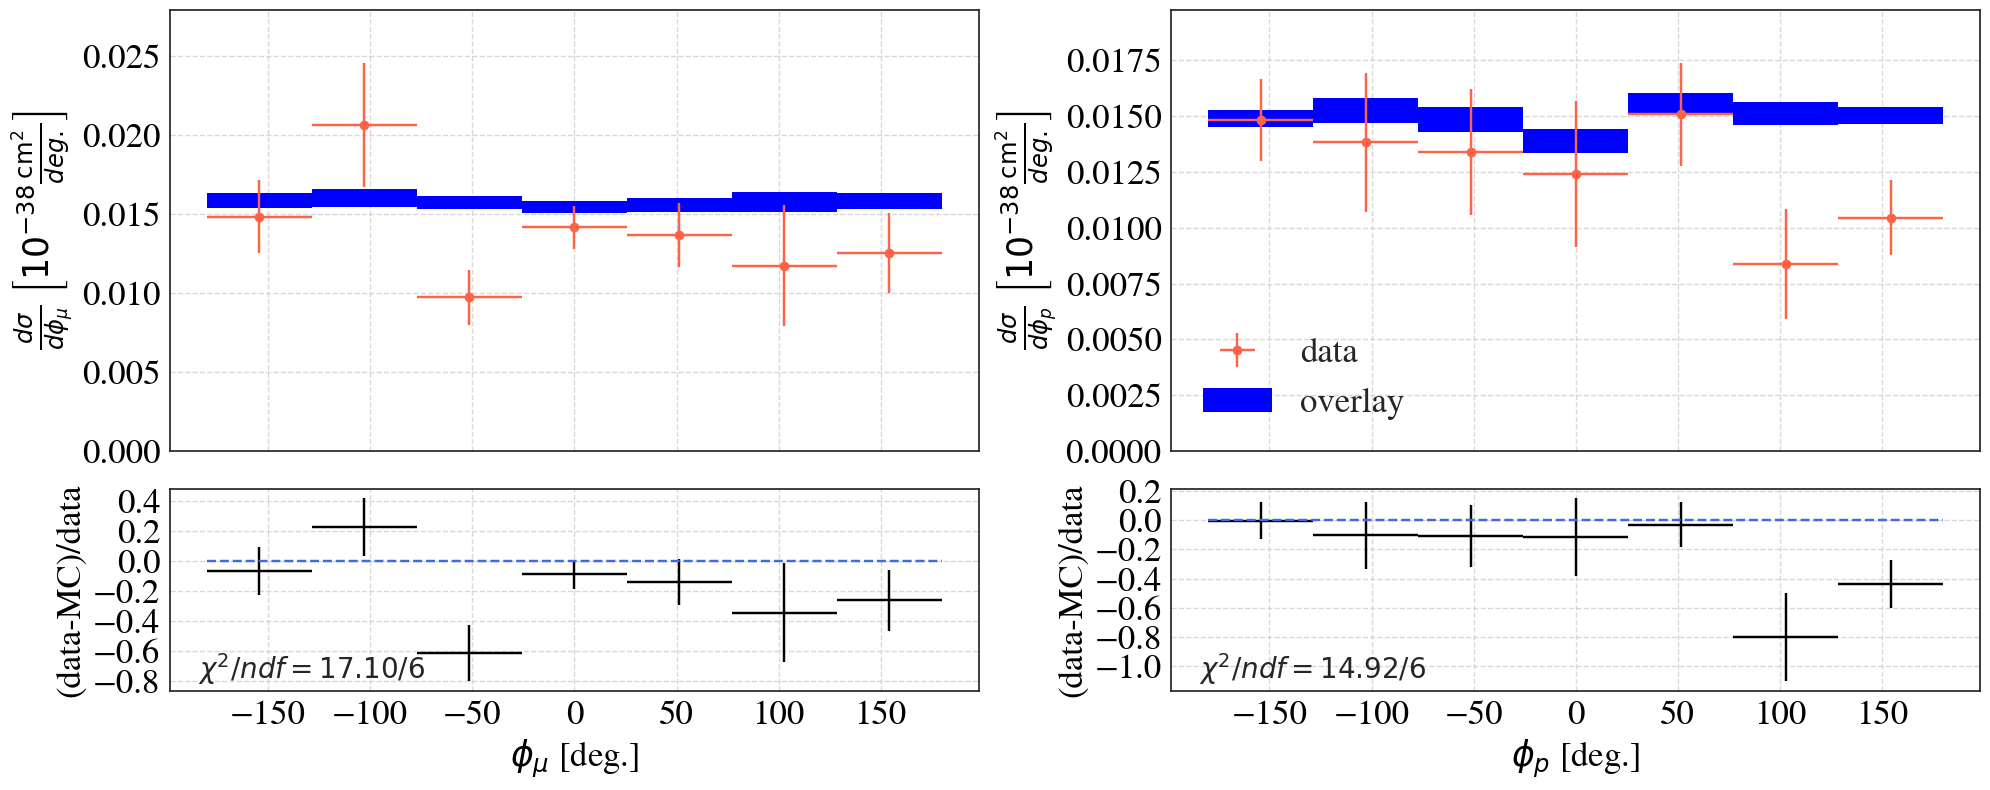

In [44]:
Xsec_dict = get_Xsecs( do_corr_phi_0=True , debug=0, do_print_Xsec=False )
draw_phi_Xsecs(Xsec_dict=Xsec_dict,filename='Xsec_Pmu_phi_Pp_phi_with_correction')

In [45]:
save_selected_samples(selected_overlay_concat , selected_CC1p , selected_beam_on , selected_beam_off,extra_name='')

saved  12127 selected overlay events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_overlay.csv
saved  9538 selected CC1p events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_09_22_selected_CC1p.csv
saved  462 selected beam_on events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_beam_on.csv
saved  15 selected beam_off events to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_beam_off.csv
